In [1]:
%pip install keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.4 MB/s eta 0:00:00 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 35.5 MB/s eta 0:00:0031m38.1 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 39.9 MB/s eta 0:00:0031m42.9 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.4/670.4 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 339.2/339.2 kB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.4/242.4 kB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.5/87.5 kB 13.8 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart 

In [2]:
%pip install keras --upgrade


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# 1-Setup

In [6]:
import os
import keras
from keras import layers
from keras import ops
from keras.layers import TextVectorization
import numpy as np
import os
import string
import random
import tensorflow
import tensorflow.data as tf_data
import tensorflow.strings as tf_strings

os.environ["KERAS_BACKEND"] = "tensorflow"

# 2-Implement a Transformer block as a layer

In [7]:
def causal_attention_mask(batch_size, n_dest, n_src, dtype):
    """
    Mask the upper half of the dot product matrix in self attention.
    This prevents flow of information from future tokens to current token.
    1's in the lower triangle, counting from the lower right corner.
    """
    i = ops.arange(n_dest)[:, None]
    j = ops.arange(n_src)
    m = i >= j - n_src + n_dest
    mask = ops.cast(m, dtype)
    mask = ops.reshape(mask, [1, n_dest, n_src])
    mult = ops.concatenate(
        [ops.expand_dims(batch_size, -1), ops.convert_to_tensor([1, 1])], 0
    )
    return ops.tile(mask, mult)


class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads, embed_dim)
        self.ffn = keras.Sequential(
            [
                layers.Dense(ff_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs):
        input_shape = ops.shape(inputs)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = causal_attention_mask(batch_size, seq_len, seq_len, "bool")
        attention_output = self.att(inputs, inputs, attention_mask=causal_mask)
        attention_output = self.dropout1(attention_output)
        out1 = self.layernorm1(inputs + attention_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)


### Què significa que la màscara d'atenció sigui causal?

Una màscara d'atenció causal garanteix que el model només atengui els testimonis actuals i passats, no els futurs. Bloqueja el flux d'informació de les paraules futures per mantenir la naturalesa autoregressiva de la generació de text.

# 3-Implement an embedding layer



In [8]:
# Create two separate embedding layers: one for tokens and one for token index (positions).

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = ops.shape(x)[-1]
        positions = ops.arange(0, maxlen, 1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions


# 4-Implement the miniature GPT model

In [9]:
vocab_size = 20000  # Only consider the top 20k words
maxlen = 80  # Max sequence size
embed_dim = 256  # Embedding size for each token
num_heads = 2  # Number of attention heads
feed_forward_dim = 256  # Hidden layer size in feed forward network inside transformer


def create_model():
    inputs = layers.Input(shape=(maxlen,), dtype="int32")
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, num_heads, feed_forward_dim)
    x = transformer_block(x)
    outputs = layers.Dense(vocab_size)(x)
    model = keras.Model(inputs=inputs, outputs=[outputs, x])
    loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(
        "adam",
        loss=[loss_fn, None],
    )  # No loss and optimization based on word embeddings from transformer block
    return model


### Quines funcions implementades als punts anteriors s'invoquen ara?

No son funcions com tal, pero s'executa el constructor per les clases:

- `TokenAndPositionEmbedding`
- `TransformerBlock`

# 5-Prepare the data for word-level language modelling

In [10]:
# Download the IMDB dataset and combine training and validation sets for a text generation task.
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0   817k      0  0:01:40  0:01:40 --:--:-- 1101k  0:00:37  0:01:16  761kk      0  0:01:50  0:00:49  0:01:01  740k    0   754k      0  0:01:48  0:00:59  0:00:49  771k    0  0:01:47  0:01:05  0:00:42  924k01:46  0:01:07  0:00:39  970k    0  0:01:42  0:01:32  0:00:10  674k


In [11]:
batch_size = 128

# The dataset contains each review in a separate text file
# The text files are present in four different folders
# Create a list all files
filenames = []
directories = [
    "aclImdb/train/pos",
    "aclImdb/train/neg",
    "aclImdb/test/pos",
    "aclImdb/test/neg",
]

# Original code:
""" 
for dir in directories:
    for f in os.listdir(dir):
        filenames.append(os.path.join(dir, f)) 
"""
# Modified code for part 7:
SAMPLE_SIZE = 500  # Adjust this number to control dataset size
for dir in directories:
    files = os.listdir(dir)[:SAMPLE_SIZE]  # Limit to the first 'SAMPLE_SIZE' files
    for f in files:
        filenames.append(os.path.join(dir, f))


print(f"{len(filenames)} files")

# Create a dataset from text files
random.shuffle(filenames)
text_ds = tf_data.TextLineDataset(filenames)
text_ds = text_ds.shuffle(buffer_size=256)
text_ds = text_ds.batch(batch_size)


def custom_standardization(input_string):
    """Remove html line-break tags and handle punctuation"""
    lowercased = tf_strings.lower(input_string)
    stripped_html = tf_strings.regex_replace(lowercased, "<br />", " ")
    return tf_strings.regex_replace(stripped_html, f"([{string.punctuation}])", r" \1")


# Create a vectorization layer and adapt it to the text
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size - 1,
    output_mode="int",
    output_sequence_length=maxlen + 1,
)
vectorize_layer.adapt(text_ds)
vocab = vectorize_layer.get_vocabulary()  # To get words back from token indices


def prepare_lm_inputs_labels(text):
    """
    Shift word sequences by 1 position so that the target for position (i) is
    word at position (i+1). The model will use all words up till position (i)
    to predict the next word.
    """
    text = tensorflow.expand_dims(text, -1)
    tokenized_sentences = vectorize_layer(text)
    x = tokenized_sentences[:, :-1]
    y = tokenized_sentences[:, 1:]
    return x, y


text_ds = text_ds.map(prepare_lm_inputs_labels, num_parallel_calls=tf_data.AUTOTUNE)
text_ds = text_ds.prefetch(tf_data.AUTOTUNE)


2000 files


2025-03-19 18:16:11.591780: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Quina és l'aplicació habitual del dataset Imdb?

L'ús més habitual del conjunt de dades d'IMDb és l'anàlisi de sentiments, classificant les ressenyes de pel·lícules com a positives o negatives. S'utilitza àmpliament per entrenar i avaluar models de classificació de textos, especialment en tasques de processament del llenguatge natural (NLP).

# 6-Implement a Keras callback for generating text

In [12]:
class TextGenerator(keras.callbacks.Callback):
    """A callback to generate text from a trained model.
    1. Feed some starting prompt to the model
    2. Predict probabilities for the next token
    3. Sample the next token and add it to the next input

    Arguments:
        max_tokens: Integer, the number of tokens to be generated after prompt.
        start_tokens: List of integers, the token indices for the starting prompt.
        index_to_word: List of strings, obtained from the TextVectorization layer.
        top_k: Integer, sample from the `top_k` token predictions.
        print_every: Integer, print after this many epochs.
    """

    def __init__(
        self, max_tokens, start_tokens, index_to_word, top_k=10, print_every=1
    ):
        self.max_tokens = max_tokens
        self.start_tokens = start_tokens
        self.index_to_word = index_to_word
        self.print_every = print_every
        self.k = top_k

    def sample_from(self, logits):
        logits, indices = ops.top_k(logits, k=self.k, sorted=True)
        indices = np.asarray(indices).astype("int32")
        preds = keras.activations.softmax(ops.expand_dims(logits, 0))[0]
        preds = np.asarray(preds).astype("float32")
        return np.random.choice(indices, p=preds)

    def detokenize(self, number):
        return self.index_to_word[number]

    def on_epoch_end(self, epoch, logs=None):
        start_tokens = [_ for _ in self.start_tokens]
        if (epoch + 1) % self.print_every != 0:
            return
        num_tokens_generated = 0
        tokens_generated = []
        while num_tokens_generated <= self.max_tokens:
            pad_len = maxlen - len(start_tokens)
            sample_index = len(start_tokens) - 1
            if pad_len < 0:
                x = start_tokens[:maxlen]
                sample_index = maxlen - 1
            elif pad_len > 0:
                x = start_tokens + [0] * pad_len
            else:
                x = start_tokens
            x = np.array([x])
            y, _ = self.model.predict(x, verbose=0)
            sample_token = self.sample_from(y[0][sample_index])
            tokens_generated.append(sample_token)
            start_tokens.append(sample_token)
            num_tokens_generated = len(tokens_generated)
        txt = " ".join(
            [self.detokenize(_) for _ in self.start_tokens + tokens_generated]
        )
        print(f"generated text:\n{txt}\n")


# Tokenize starting prompt
word_to_index = {}
for index, word in enumerate(vocab):
    word_to_index[word] = index

start_prompt = "this movie is"
start_tokens = [word_to_index.get(_, 1) for _ in start_prompt.split()]
num_tokens_generated = 40
text_gen_callback = TextGenerator(num_tokens_generated, start_tokens, vocab)


### Quin canvi faríeu al codi perquè sempre triàs la paraula més probable?

```python
def sample_from(self, logits):
   logits, indices = ops.top_k(logits, k=1, sorted=True)  # Get the top 1 prediction
   # ... 
   return int(indices[0])  # Return the most likely word
```

# 7-Train the model

### Entrenau el model amb un altre dataset de text d'una mida suficient.

Modificació realitzada per reduïr el _size_ del dataset:
```python
# Original code:
""" 
for dir in directories:
    for f in os.listdir(dir):
        filenames.append(os.path.join(dir, f)) 
"""
# Modified code for part 7:
SAMPLE_SIZE = 500  # Adjust this number to control dataset size
for dir in directories:
    files = os.listdir(dir)[:SAMPLE_SIZE]  # Limit to the first 'SAMPLE_SIZE' files
    for f in files:
        filenames.append(os.path.join(dir, f))
```

Aquest codi redueix el dataset en 2000 arxius. Es pot modificar el valor de `SAMPLE_SIZE`.

In [14]:
# Note: This code should preferably be run on GPU.
model = create_model()
model.fit(text_ds, verbose=1, epochs=25, callbacks=[text_gen_callback])

Epoch 1/25
     16/Unknown 33s 2s/step - loss: 9.0501

2025-03-19 18:18:32.223882: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/carlos/Development/IEDIB_CEIA_2024-25/Modelos de Inteligencia Artificial/Bloque 6/Actividades/6.1/.venv/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


generated text:
this movie is , is . . to . the . and the the , , , of the the the i . a . of , the and a , of . a and i of to the , to to the a

16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - loss: 9.0020
Epoch 2/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 6.5976generated text:
this movie is the of the a . i  , the , the , to of . the the the , [UNK] . and the . the , a [UNK] a is the [UNK] i of the it the the it . a

16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - loss: 6.5945
Epoch 3/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 6.3734

2025-03-19 18:19:40.911333: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


generated text:
this movie is , , the story of . the best . i was . the [UNK] is a film of the best and the , , . the worst the movie the plot , the story of a movie i was , it

16/16 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - loss: 6.3676
Epoch 4/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 5.8907generated text:
this movie is one in the worst , , but the film , this film and the story . the movie , and the [UNK] and the movie of the film to see this film , they have not to have a lot ,

16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - loss: 5.8857
Epoch 5/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 5.4625generated text:
this movie is a movie was a great movie , but the movie is a great movie that 's good . i can 't be the best movie . it was an interesting . the story that this is not a good . i

16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - loss: 5.4594
Epoch 6/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 5.1531generated text:
this movie is so i saw this movie was one of the first , but it i

2025-03-19 18:21:50.667706: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


generated text:
this movie is one of the film that they had the [UNK] and he is an old [UNK] " . this film , but i was very funny and the first time and then you 'll be one of this one . but it

16/16 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - loss: 4.8858
Epoch 8/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 4.6640generated text:
this movie is about it . . but the best . he has a [UNK] . the first time i was a great and the first time to a very well , and is just didn 't even though they were the story is

16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - loss: 4.6622
Epoch 9/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 4.4568generated text:
this movie is a [UNK] [UNK] " . . this film was very interesting , but i was a movie that a good thing about the movie , but a few hours and not the story is one of his father has a [UNK]

16/16 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - loss: 4.4557
Epoch 10/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 4.2813generated text:
this movie is a film . the most of t

2025-03-19 18:25:53.862774: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


generated text:
this movie is a good movie , and there is a movie and then i can be made with a lot of all . i 'm translating movies . i had very good actor until the first , so . the plot . i

16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - loss: 3.5221
Epoch 16/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 3.3804generated text:
this movie is the bad that bad movie , it wasn 't really bad it 's hard to be good as well done . it is so it is great . the story that you want to make good as a great , but

16/16 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - loss: 3.3793
Epoch 17/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 3.2396generated text:
this movie is about a good as it has been a lot of times , but this movie , i have been looking for me wrong it is not to watch . i have been watching it was the acting , but i was

16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - loss: 3.2385
Epoch 18/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 3.1021generated text:
this movie is not just as a comedy but the bes

# 8-Canviau el codi de generació de text, de forma que en lloc d'aturar quan ha generat un nombre de tokens, aturi quan genera un punt. D'aquesta forma, les frases generades sempre seran completes.

[Claude share chat](https://claude.ai/share/f2373237-ada9-4c2c-884a-735fc71085bc)

Seguint les indicaciones de Claude.ai, la modificació a realitzar en el codi seria la següent

```python
def sample_from(self, logits):
   return np.argmax(logits).astype("int32") # return the index with the highest value
```

In [ ]:
## FROM JORDI
class TextGenerator(keras.callbacks.Callback):
    """A callback to generate text from a trained model.
    1. Feed some starting prompt to the model
    2. Predict probabilities for the next token
    3. Sample the next token and add it to the next input
    4. Stop when a period is generated or max_tokens is reached

    Arguments:
        max_tokens: Integer, the number of tokens to be generated after prompt.
        start_tokens: List of integers, the token indices for the starting prompt.
        index_to_word: List of strings, obtained from the TextVectorization layer.
        top_k: Integer, sample from the `top_k` token predictions.
        print_every: Integer, print after this many epochs.
    """

    def __init__(
        self, max_tokens, start_tokens, index_to_word, top_k=10, print_every=1
    ):
        self.max_tokens = max_tokens
        self.start_tokens = start_tokens
        self.index_to_word = index_to_word
        self.print_every = print_every
        self.k = top_k

    def sample_from(self, logits):
        return np.argmax(logits).astype("int32") # return the index with the highest value

    def detokenize(self, number):
        return self.index_to_word[number]

    def on_epoch_end(self, epoch, logs=None):
        start_tokens = [_ for _ in self.start_tokens]
        if (epoch + 1) % self.print_every != 0:
            return
        num_tokens_generated = 0
        tokens_generated = []
        while num_tokens_generated <= self.max_tokens:
            pad_len = maxlen - len(start_tokens)
            sample_index = len(start_tokens) - 1
            if pad_len < 0:
                x = start_tokens[:maxlen]
                sample_index = maxlen - 1
            elif pad_len > 0:
                x = start_tokens + [0] * pad_len
            else:
                x = start_tokens
            x = np.array([x])
            y, _ = self.model.predict(x, verbose=0)
            sample_token = self.sample_from(y[0][sample_index])
            tokens_generated.append(sample_token)
            start_tokens.append(sample_token)
            num_tokens_generated = len(tokens_generated)

            # Check if the generated token is a period
            if self.detokenize(sample_token) == '.':
                break

        txt = " ".join(
            [self.detokenize(_) for _ in self.start_tokens + tokens_generated]
        )
        print(f"generated text:\n{txt}\n")

word_to_index = {}
for index, word in enumerate(vocab):
    word_to_index[word] = index

start_prompt = "this movie is"
start_tokens = [word_to_index.get(_, 1) for _ in start_prompt.split()]
num_tokens_generated = 40
text_gen_callback2 = TextGenerator(num_tokens_generated, start_tokens, vocab)

In [17]:
model2 = create_model()

model2.fit(text_ds, verbose=1, epochs=10, callbacks=[text_gen_callback2])

Epoch 1/10
     16/Unknown 33s 2s/step - loss: 9.1276generated text:
this movie is , .

16/16 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - loss: 9.0799
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 6.6201generated text:
this movie is the to of the to .

16/16 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - loss: 6.6158
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 6.3851generated text:
this movie is a movie .

16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - loss: 6.3785
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 5.9048generated text:
this movie is a film , i 'm this is a little movie , but it 's a lot the movie .

16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - loss: 5.9002
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 5.4817generated text:
this movie is a little film is a big film to the story of the movie 's not , but the story and this film was a film .

16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - loss: 5.4783
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 5.1527

2025-03-19 18:38:14.059149: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


generated text:
this movie is just a film , but it 's a very little movie .

16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - loss: 5.1502
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 4.8934generated text:
this movie is one of the best of the movie is not even though it is a [UNK] of the movie that i was not not a few minutes in an [UNK] ) , the film is one is a lot , but this

16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - loss: 4.8911
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 4.6629generated text:
this movie is a great plot and was a very funny .

16/16 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - loss: 4.6613
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 4.4628generated text:
this movie is the film is a little film , but that i saw this movie is a good and i 'm not a very well , but i had a great .

16/16 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - loss: 4.4616
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 4.2883generated text:
this movie is a very good film .

16/1

# Xatbots basats en LLM

# 9-Comparau el rànquing de xatbots disponible a lmarena.ai amb el dels apunts. Quines diferències hi destacau?

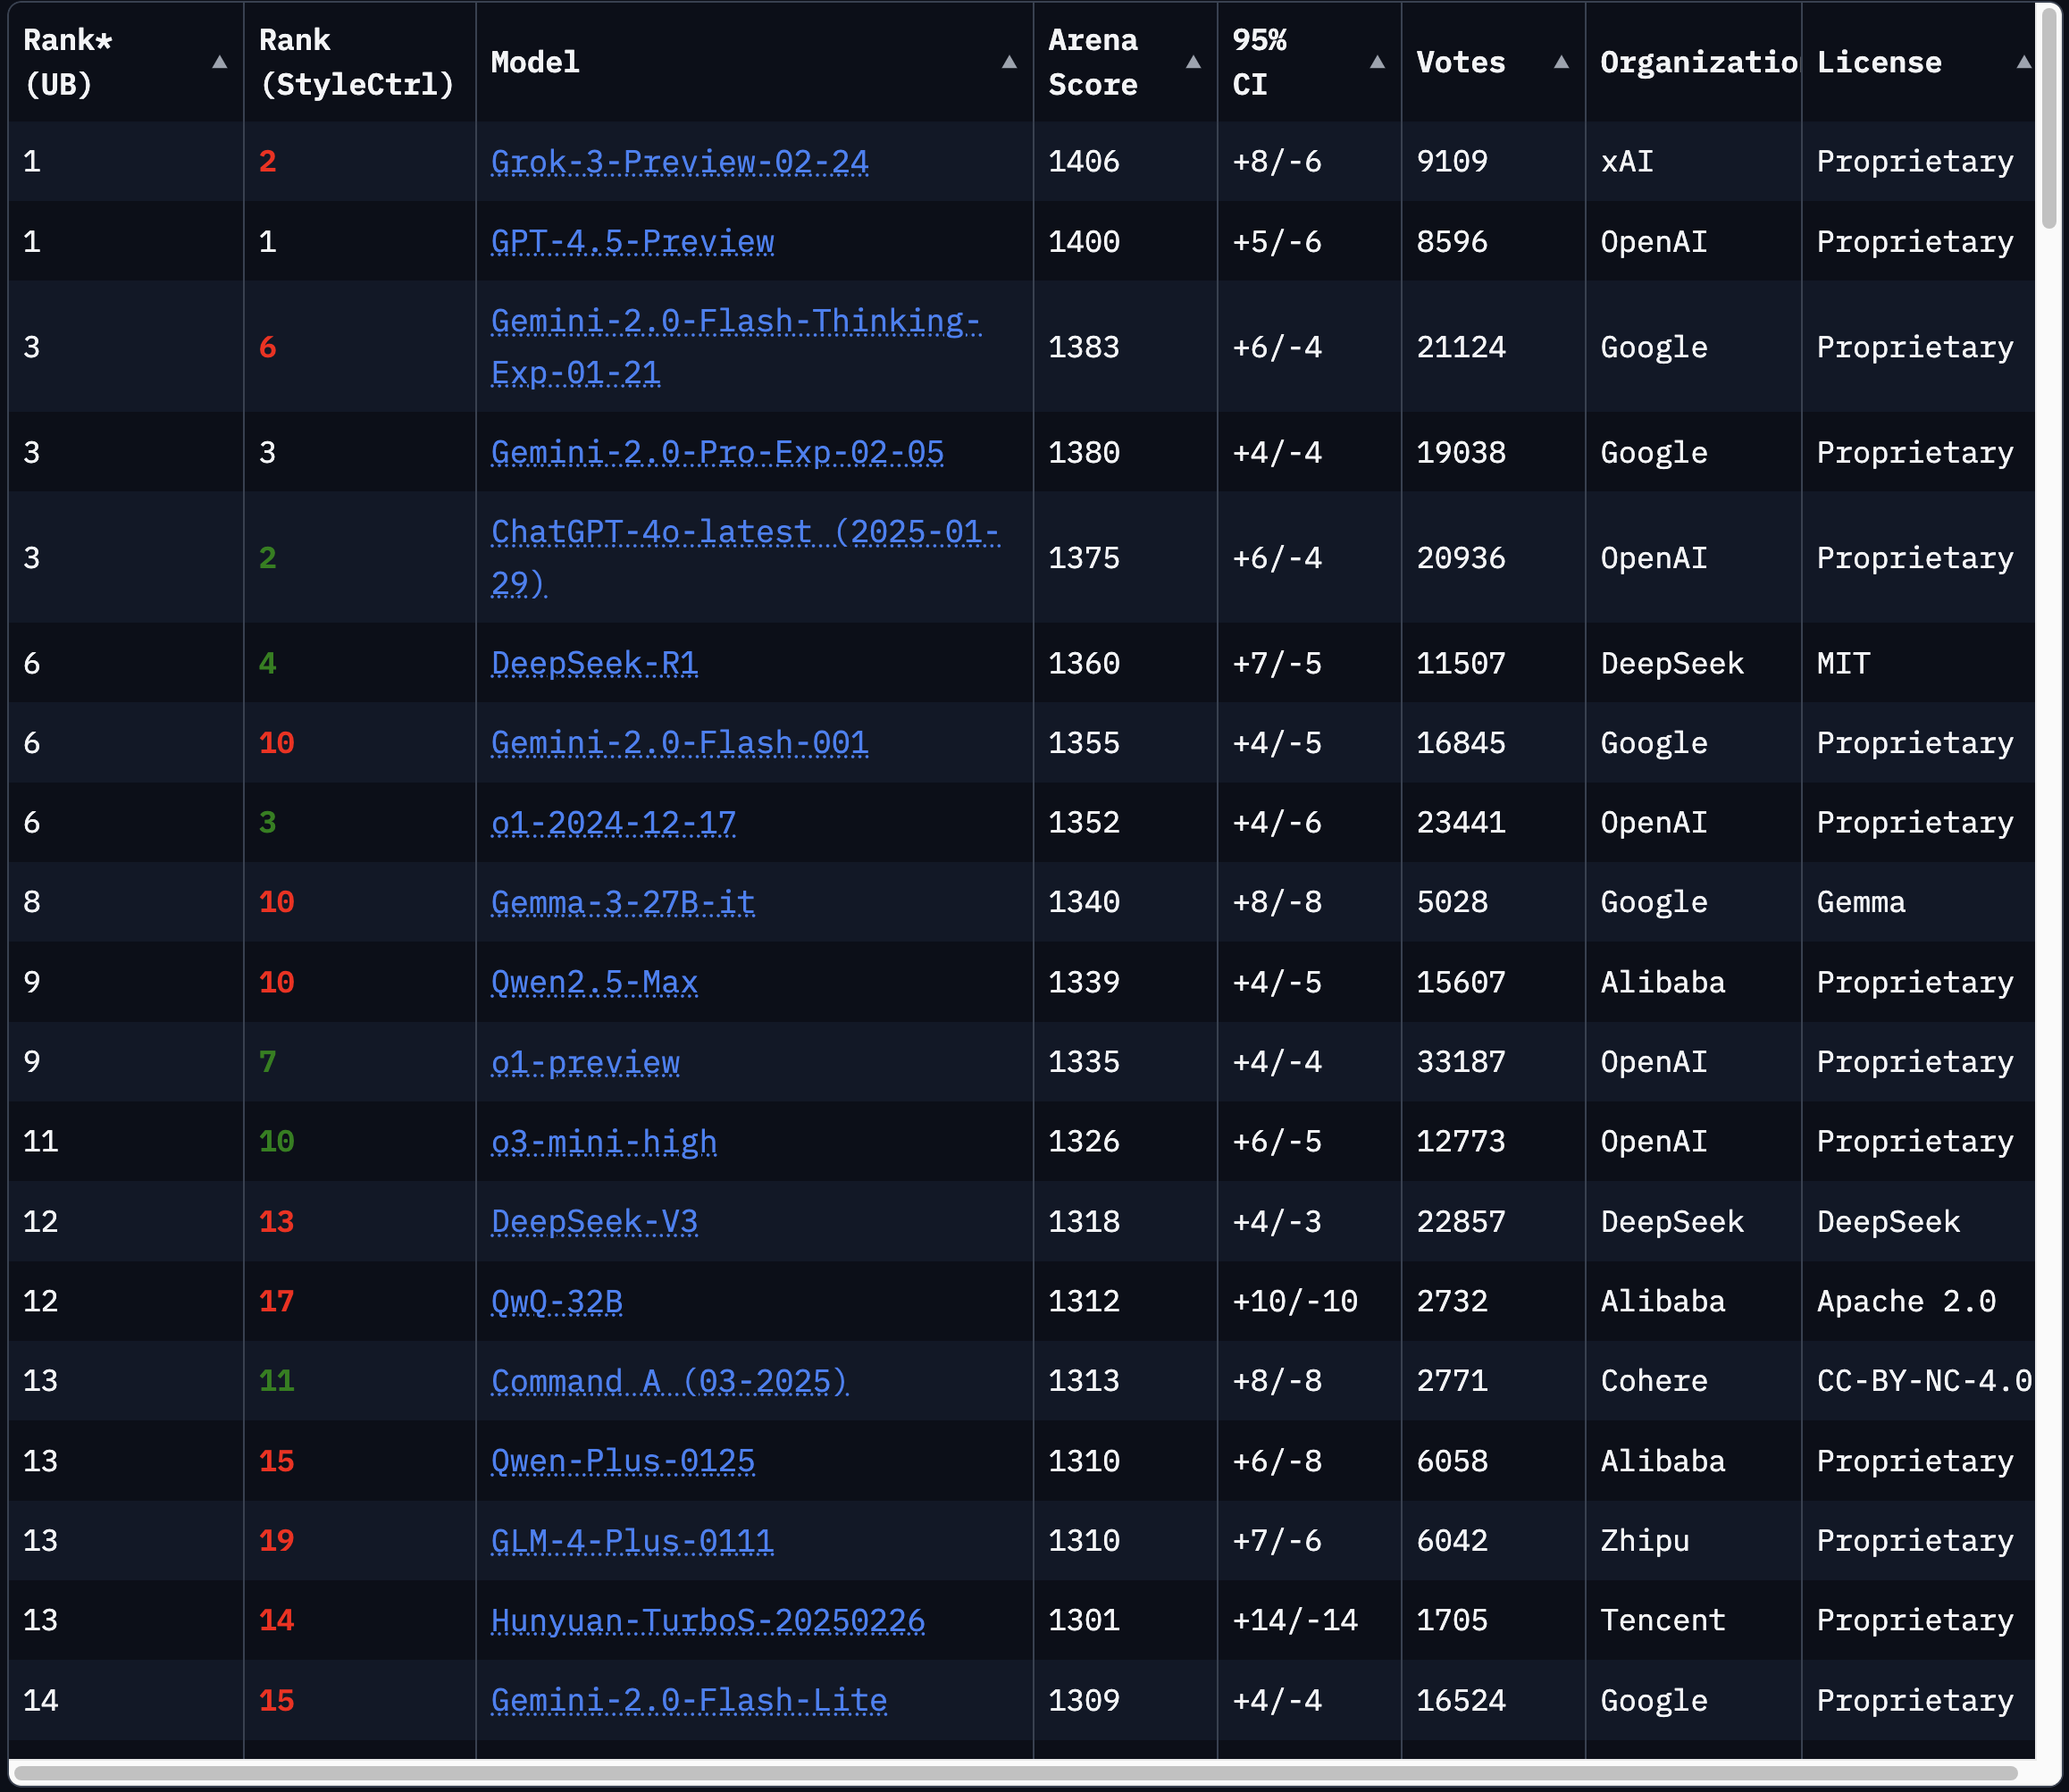

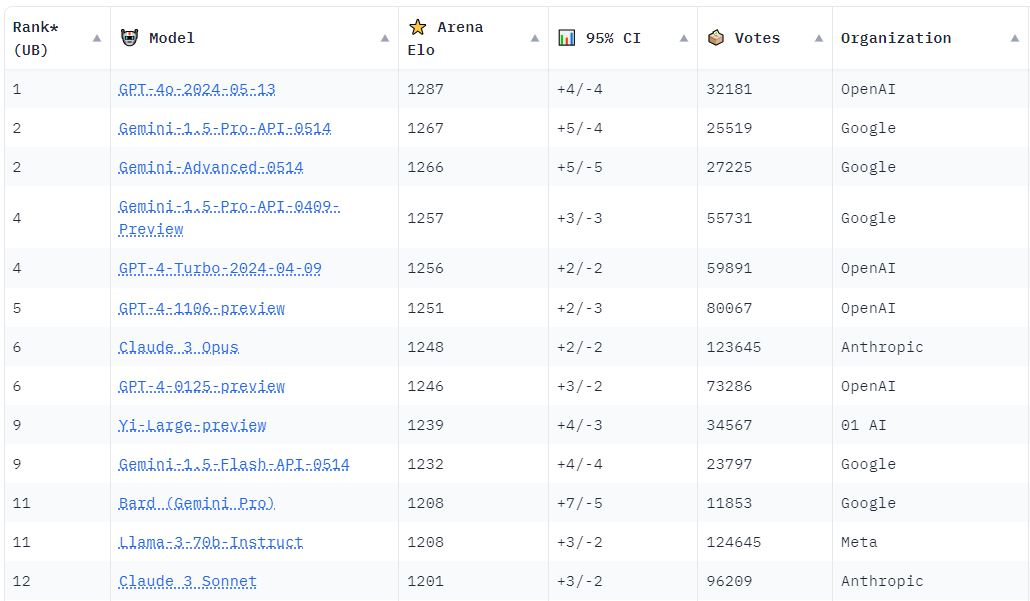


Suposadament, la preview de GROK 3 lidera el rànking per a lmarena però els apunts no indiquen el mateix. Com es una preview, pot ser que la taula dels apunts no estigui actualitzada al cent per cent. Si no ens fixem en aques en concret, podrem veure que les que encapsalen ambdues taules son GPT y Gemini, però en versions diferents (de nou, podría ser a una desactualització).

Si miram am més deteniment, podrem veure que hi ha models que no tenen tan de renou però que s'acosten cada vegada més y més. Això fa pensar en una "caiguda" o "fi" del monopoli que va iniciar OpenAI amb l'ús dels agents d'IA.

# 10-Provau alguns LLM que hi ha disponibles a través de la interfície de xat de HuggingFace i comentau les diferències que hi heu observat. Hi ha models recents com DeepSeek 3 i Grok 3?

No ceoneixia aquesta utilitat que et permet fer tests amb diferents models (y bastant al dia). Es una pena que GROK3 no estigui disponible però si que m'ha parescut interesat provar Mistral ja que no l'havia probada. Comparant amb Claude y GPT, es molt clar la tendencia de cadascuna: Claude tendeix a ser més técnica y precissa però amb certes limitacions, y GPT a donar un discurs kolomètric.